Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [4]:
df_voles = pd.read_csv("http://bit.ly/2IgDF0E")

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [47]:
print(df_voles.head())

   site  voles  veg   soil
0     1     17    4  moist
1     2     30   33  moist
2     3     54   94  moist
3     4     49   64  moist
4     5     34   32  moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

/tmp/ipykernel_94/1064517035.py:7: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


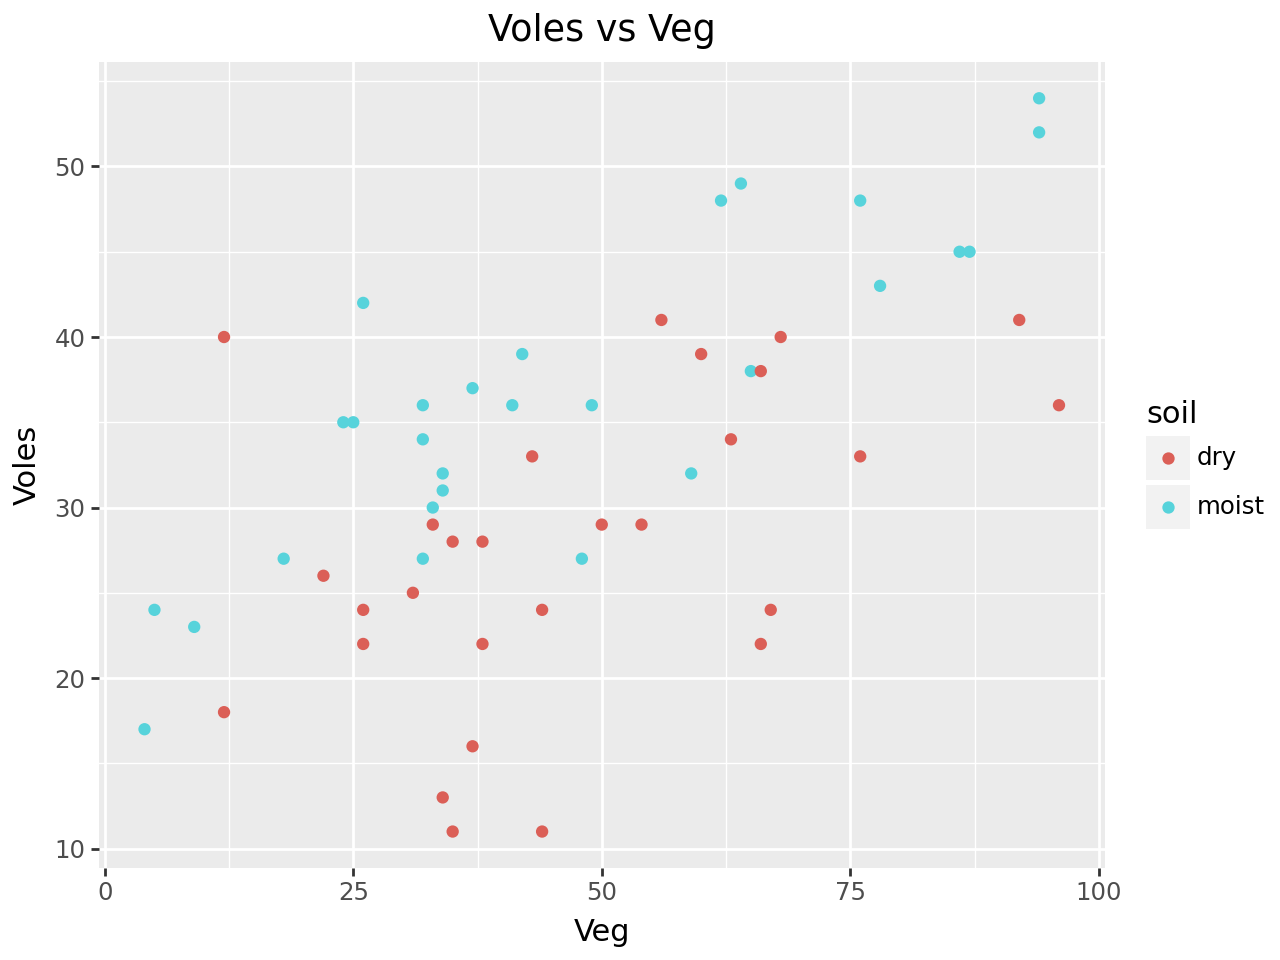

In [48]:
plot = (
    ggplot(df_voles, aes(x='veg', y='voles')) +
    geom_point(aes(color='soil')) +
    labs(title='Voles vs Veg', x='Veg', y='Voles')
)

print(plot)

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [49]:
df_voles = df_voles.dropna()
features = ['soil', 'veg']
X = df_voles[features] 
y = df_voles['voles']

X.head()

,soil,veg
0,moist,4
1,moist,33
2,moist,94
3,moist,64
4,moist,32


In [50]:
ct = make_column_transformer(
    ('passthrough', ['veg']),
    (OneHotEncoder(drop=['moist']), ['soil'])
)

ct.fit_transform(X)[:5]

array([[ 4.,  0.],
       [33.,  0.],
       [94.,  0.],
       [64.,  0.],
       [32.,  0.]])

In [51]:
pipeline = make_pipeline(
    ct,
    LinearRegression()
)

pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['veg']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop=['moist']),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [52]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [53]:
regression_table = get_regression_table(pipeline)
print(regression_table)

                      term   estimate
0         passthrough__veg   0.259069
1  onehotencoder__soil_dry  -9.100298
2                intercept  24.564324


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

Protecting a site with high vegetation cover can be a more effective way to preserve the vole population because voles and veg are positively associated; for every 1 unit increase in veg, vole increases by ~0.259, with soil type being constant.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

/tmp/ipykernel_94/168259536.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


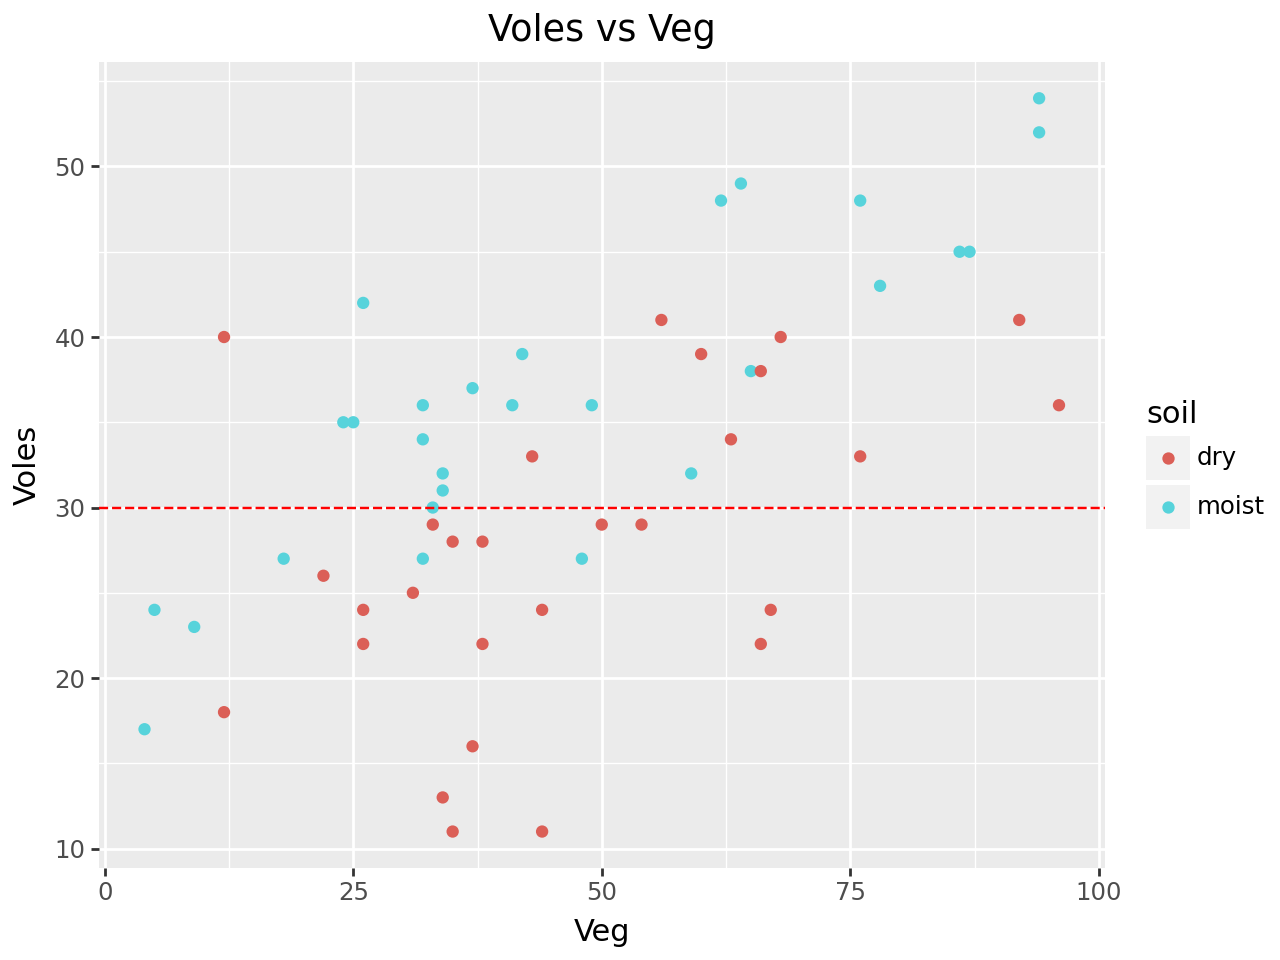

In [54]:
plot = (
    ggplot(df_voles, aes(x='veg', y='voles')) +
    geom_point(aes(color='soil')) +
    geom_hline(yintercept=30, linetype='dashed', color='red') +
    labs(title='Voles vs Veg', x='Veg', y='Voles')
)

print(plot)

They need to maintain a minimum of ~32% veg roughly 

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:**

In [55]:
pipeline.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))

array([34.92708151])

34.92708151 would be the possible vole population the site might be able to support